# Affine Spatial Transformer Network for Image Registration

In [1]:
import os
import skimage
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from nibabel.analyze import AnalyzeHeader
from torchvision import transforms
from PIL import Image

## Create Torch Dataset

In [2]:
from torch.utils.data import Dataset, DataLoader
import os, torch

In [3]:
def normalize(image):
    image = (image - image.min()) / (image.max() - image.min())
    return image.astype('float32')

class MRIDataset(Dataset):
    def __init__(self, root, transform=None, n_slices=120):
        self.transform = transform
        self.root = root
        self.n_slices = n_slices
        
    def __len__(self):
        return len(os.listdir(self.root))*self.n_slices
    
    def __getitem__(self, idx): 
        subdir = os.listdir(self.root)[idx//self.n_slices]
        slice_number = idx % self.n_slices
        
        f = open(f'{self.root}/{subdir}/{subdir}.native.mri.hdr', 'rb')
        binblock = f.read()
        hdr = AnalyzeHeader(binblock)

        image_shape = hdr.get_data_shape()
        width, height, depth, _ = image_shape

        f = open(f'{self.root}/{subdir}/{subdir}.native.mri.img', 'rb')
        raw_image = np.fromfile(f, np.uint16)
        image = raw_image.reshape(image_shape).squeeze()
        
        image = image.swapaxes(0,1)
        image = image[:, ::-1]
        image = image[slice_number]
        image = normalize(image)

        if self.transform is not None:
            target = torch.Tensor((image-self.transform.transforms[-1].mean[0])/
                                    self.transform.transforms[-1].std[0])
            tf_image = self.transform(image)
        else: 
            return image
            
        return tf_image, target

In [4]:
data=MRIDataset("orig/LPBA40/native_space")

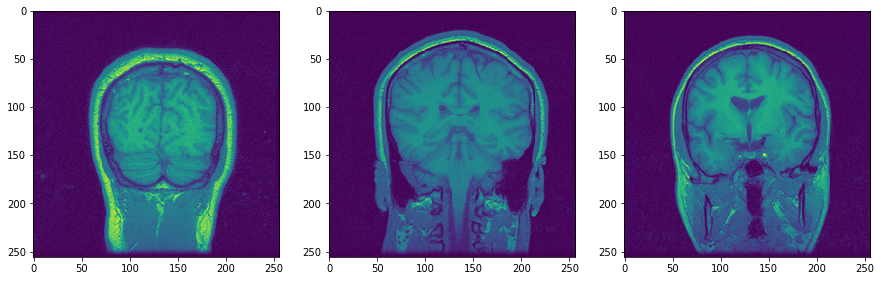

In [5]:
f, (ax0,ax1,ax2) = plt.subplots(1,3,figsize=(15,10))
ax0.imshow(data[20])
ax1.imshow(data[49])
ax2.imshow(data[789])

In [6]:
tfms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomAffine(45, (0.2,0.2), (0.6,0.9), 5, Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize([0.1408],[0.1716])
])

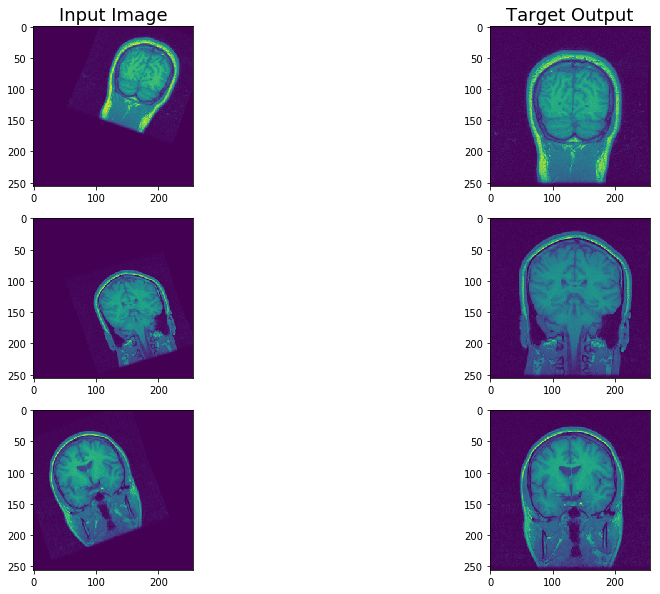

In [7]:
data=MRIDataset("orig/LPBA40/native_space",tfms)
f, (ax0,ax1,ax2) = plt.subplots(3,2,figsize=(15,10))
ax0[0].set_title("Input Image", fontsize=18)
ax0[0].imshow(data[20][0].numpy().squeeze())
ax1[0].imshow(data[49][0].numpy().squeeze())
ax2[0].imshow(data[789][0].numpy().squeeze())

ax0[1].set_title("Target Output", fontsize=18)
ax0[1].imshow(data[20][1].numpy().squeeze())
ax1[1].imshow(data[49][1].numpy().squeeze())
ax2[1].imshow(data[789][1].numpy().squeeze())

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

bs = 32
dl = DataLoader(data, batch_size=bs,
                        shuffle=True, num_workers=4)

In [9]:
a=next(iter(dl))
a[0].shape, a[1].shape

(torch.Size([32, 1, 256, 256]), torch.Size([32, 256, 256]))

In [10]:
a[0].mean(), a[0].std(), a[0].max()

(tensor(-0.2943), tensor(1.0128), tensor(4.9016))

In [11]:
a[1].mean(), a[1].std(), a[1].max()

(tensor(0.1815), tensor(1.2242), tensor(5.0070))

## STN

In [12]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

In [13]:
# Add more loss functions

In [14]:
class Net(nn.Module):
    def __init__(self, image_size):
        super(Net, self).__init__()

        # Spatial transformer localization-network
        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5, stride=2),
            nn.ReLU(True)
        )
        self.output_size = ((image_size-7)//2+1-5)//2+1

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * self.output_size**2, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )

        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))
        
        # A final layer to adjust for interpolation
        self.conv1 = nn.Conv2d(1,1,kernel_size=3,padding=1,bias=False)
        self.conv1.weight.data.zero_()

    def forward(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 10 * self.output_size**2)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)
        
        res_out = self.conv1(x)
        x = x + res_out
        
        return x

model = Net(256).to(device)

In [15]:
optimizer = optim.SGD(model.parameters(), lr=0.005)
# optimizer = optim.Adam(model.parameters())

loss_fn = nn.L1Loss()


def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(dl):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 50*bs == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(dl.dataset),
                100. * batch_idx / len(dl), loss.item()))

# Not used
def test():
    with torch.no_grad():
        model.eval()
        test_loss = 0
        correct = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            # sum up batch loss
            test_loss += F.nll_loss(output, target, size_average=False).item()
            # get the index of the max log-probability
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
              .format(test_loss, correct, len(test_loader.dataset),
                      100. * correct / len(test_loader.dataset)))

In [16]:
def convert_image_np(inp):
    """Convert a Tensor to numpy image."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.1408])
    std = np.array([0.1716])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

def visualize_stn():
    with torch.no_grad():
        # Get a batch of training data
        data = next(iter(dl))
        moving, target = data[0].to(device), data[1].cpu()

        input_tensor = moving.cpu()
        transformed_input_tensor = model(moving).cpu()

        in_grid = convert_image_np(
            torchvision.utils.make_grid(input_tensor))

        out_grid = convert_image_np(
            torchvision.utils.make_grid(transformed_input_tensor))
        
        target_grid = convert_image_np(
            torchvision.utils.make_grid(target[:,None]))
        
        # Plot the results side-by-side
        f, axarr = plt.subplots(3, 1, figsize=(24,24))
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Moving Images')

        axarr[1].imshow(out_grid)
        axarr[1].set_title('Output Images')
        
        axarr[2].imshow(target_grid)
        axarr[2].set_title('Target Images')

In [42]:
for epoch in range(1, 20):
    train(epoch)
#     test()

Train Epoch: 1 [0/4800 (0%)]	Loss: 0.731582
Train Epoch: 1 [1600/4800 (33%)]	Loss: 0.688744
Train Epoch: 1 [3200/4800 (67%)]	Loss: 0.711489
Train Epoch: 2 [0/4800 (0%)]	Loss: 0.680402
Train Epoch: 2 [1600/4800 (33%)]	Loss: 0.698418
Train Epoch: 2 [3200/4800 (67%)]	Loss: 0.677861
Train Epoch: 3 [0/4800 (0%)]	Loss: 0.713224
Train Epoch: 3 [1600/4800 (33%)]	Loss: 0.691604
Train Epoch: 3 [3200/4800 (67%)]	Loss: 0.700013
Train Epoch: 4 [0/4800 (0%)]	Loss: 0.682238
Train Epoch: 4 [1600/4800 (33%)]	Loss: 0.695069
Train Epoch: 4 [3200/4800 (67%)]	Loss: 0.665430
Train Epoch: 5 [0/4800 (0%)]	Loss: 0.699092
Train Epoch: 5 [1600/4800 (33%)]	Loss: 0.693434
Train Epoch: 5 [3200/4800 (67%)]	Loss: 0.687053
Train Epoch: 6 [0/4800 (0%)]	Loss: 0.727849
Train Epoch: 6 [1600/4800 (33%)]	Loss: 0.686483
Train Epoch: 6 [3200/4800 (67%)]	Loss: 0.675860
Train Epoch: 7 [0/4800 (0%)]	Loss: 0.705171
Train Epoch: 7 [1600/4800 (33%)]	Loss: 0.722384
Train Epoch: 7 [3200/4800 (67%)]	Loss: 0.703815
Train Epoch: 8 [0/48

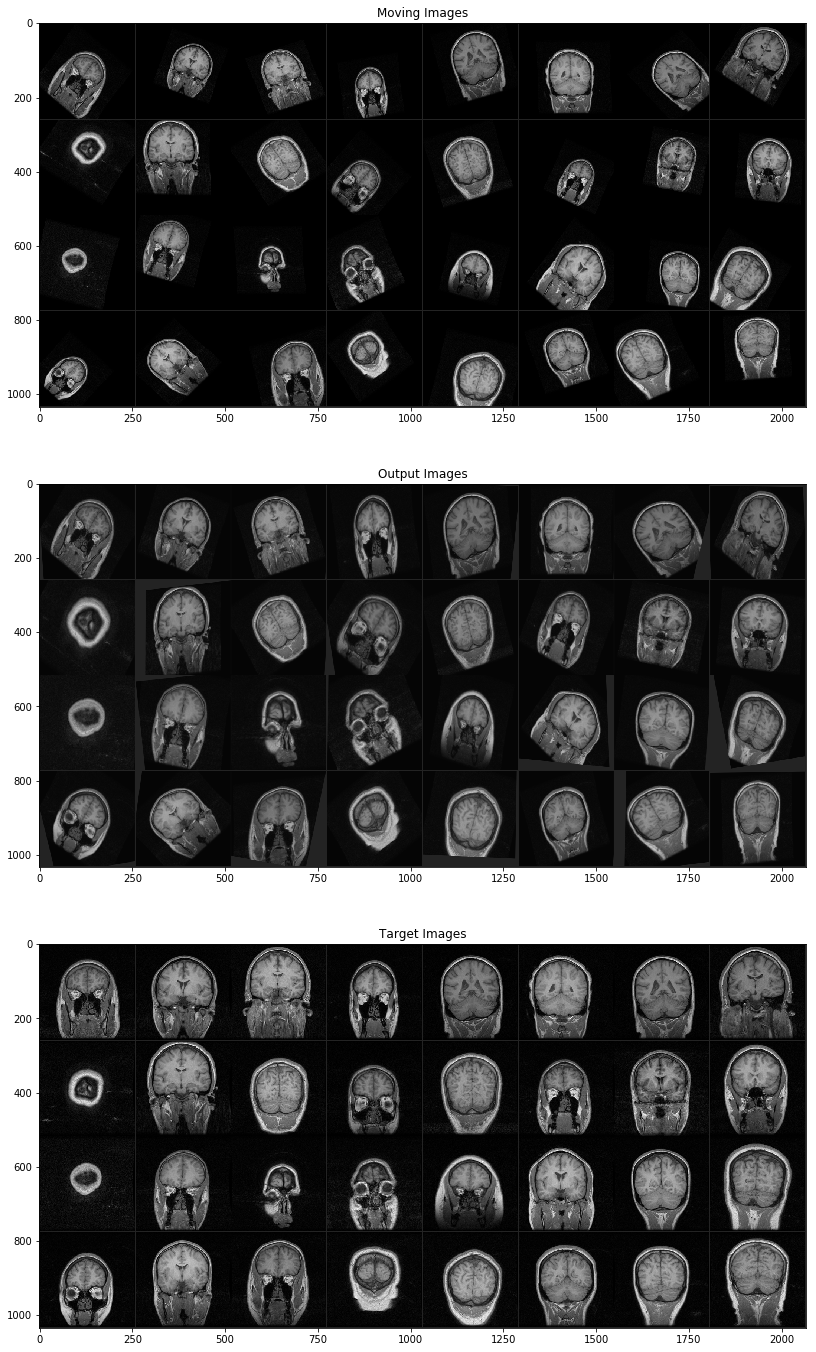

In [43]:
visualize_stn()

Todo:

- Train for longer
- Create different loss functions
- Compare to SimpleElastix Image library
- Add masks and calculate other losses (Jaccard, MI, ROC)

## Add Masks

In [17]:
class MRIMaskDataset(Dataset):
    def __init__(self, root, transform, n_slices=120):
        self.transform = transform
        self.root = root
        self.n_slices = n_slices
        
    def __len__(self):
        return len(os.listdir(self.root))*self.n_slices
    
    def __getitem__(self, idx): 
        subdir = os.listdir(self.root)[idx//self.n_slices]
        slice_number = idx % self.n_slices
        
        # MRI
        f = open(f'{self.root}/{subdir}/{subdir}.native.mri.hdr', 'rb')
        binblock = f.read()
        hdr = AnalyzeHeader(binblock)

        image_shape = hdr.get_data_shape()
        width, height, depth, _ = image_shape

        f = open(f'{self.root}/{subdir}/{subdir}.native.mri.img', 'rb')
        raw_image = np.fromfile(f, np.uint16)
        image = raw_image.reshape(image_shape).squeeze()
        
        image = image[::-1]
        image = image.swapaxes(0,1)
        image = image[slice_number]
        image = normalize(image)

        # Brain Mask
        f = open(f'{self.root}/{subdir}/{subdir}.native.brain.mask.hdr', 'rb')
        binblock = f.read()
        hdr = AnalyzeHeader(binblock)

        mask_shape = hdr.get_data_shape()
        width, height, depth, _ = mask_shape
        
        f = open(f'{self.root}/{subdir}/{subdir}.native.brain.mask.img', 'rb')
        raw_mask = np.fromfile(f, np.uint8)
        mask = raw_mask.reshape(mask_shape).squeeze()
        
        mask = mask[::-1]
        mask = mask.swapaxes(0,1)
        mask = mask[slice_number]
        mask = mask.astype("float32")
        mask /= 255
            
        moving = self.transform({"image": image, "mask": mask})
            
        return moving["image"], moving["target"], moving["mask"], torch.Tensor(mask)

In [18]:
import torchvision.transforms.functional as TF
import random

In [19]:
def mask_transforms(data):
    assert "image" in data and "mask" in data
    
    angle = random.randint(-25,25)
    trans_x = random.random()*0.4-0.2
    trans_y = random.random()*0.4-0.2
    scale = random.random()*0.25 + 0.7
    shear = random.random()*10-5
    
    image = TF.to_pil_image(data["image"])
    image = TF.affine(image, angle, (trans_x,trans_y), scale, shear,Image.BILINEAR)
    image = TF.to_tensor(image)
    image = TF.normalize(image, [0.1408],[0.1716])
    
    mask = TF.to_pil_image(data["mask"].astype("float32"))
    mask = TF.affine(mask, angle, (trans_x,trans_y), scale, shear,Image.BILINEAR)
    mask = TF.to_tensor(mask)
    
    target = TF.to_tensor(data["image"])
    target = TF.normalize(target, [0.1408],[0.1716])
    
    return {"image": image, "mask":mask, "target":target}

In [20]:
data = MRIMaskDataset("orig/LPBA40/native_space", mask_transforms)

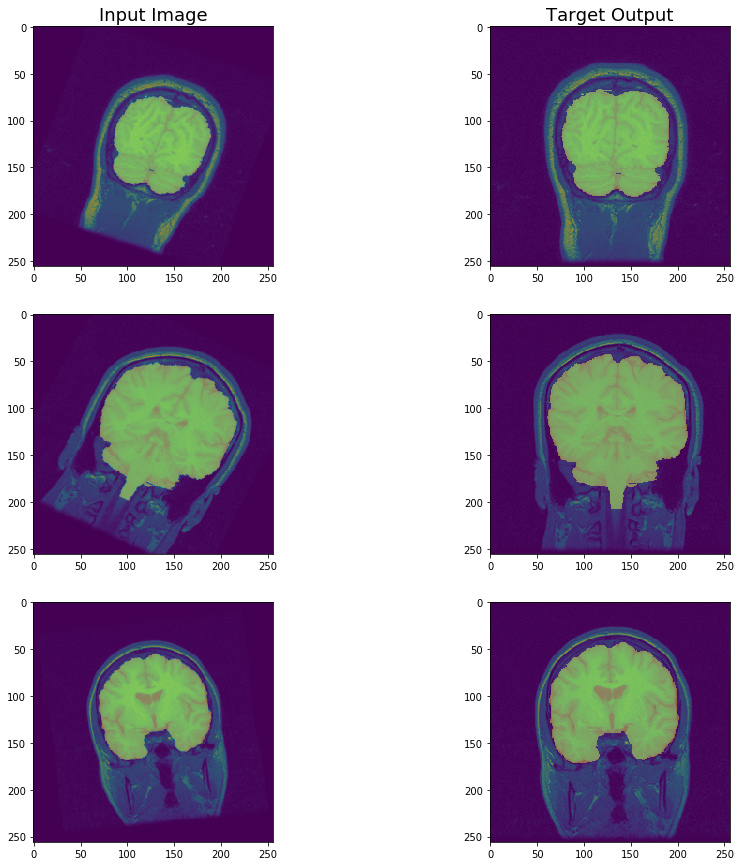

In [21]:
f, (ax0,ax1,ax2) = plt.subplots(3,2,figsize=(15,15))

im1 = data[20]
im2 = data[49]
im3 = data[789]

ax0[0].set_title("Input Image", fontsize=18)
ax0[0].imshow(im1[0].numpy().squeeze())
ax1[0].imshow(im2[0].numpy().squeeze())
ax2[0].imshow(im3[0].numpy().squeeze())

ax0[1].set_title("Target Output", fontsize=18)
ax0[1].imshow(im1[1].numpy().squeeze())
ax1[1].imshow(im2[1].numpy().squeeze())
ax2[1].imshow(im3[1].numpy().squeeze())

ax0[0].imshow(im1[2].numpy().squeeze(), alpha=0.4)
ax1[0].imshow(im2[2].numpy().squeeze(), alpha=0.4)
ax2[0].imshow(im3[2].numpy().squeeze(), alpha=0.4)

ax0[1].imshow(im1[3].numpy().squeeze(), alpha=0.4)
ax1[1].imshow(im2[3].numpy().squeeze(), alpha=0.4)
ax2[1].imshow(im3[3].numpy().squeeze(), alpha=0.4)

In [22]:
bs = 128
data = MRIMaskDataset("orig/LPBA40/native_space", mask_transforms)
dl = DataLoader(data, batch_size=bs, shuffle=True, num_workers=4)

In [23]:
class Net(nn.Module):
    def __init__(self, image_size):
        super(Net, self).__init__()

        # Spatial transformer localization-network
        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5, stride=2),
            nn.ReLU(True)
        )
        self.output_size = ((image_size-7)//2+1-5)//2+1

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * self.output_size**2, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )

        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))
        
        # A final layer to adjust for interpolation
        self.conv1 = nn.Conv2d(1,1,kernel_size=3,padding=1,bias=False)
        self.conv1.weight.data.zero_()

    def forward(self, x, mask):
        xs = self.localization(x)
        xs = xs.view(-1, 10 * self.output_size**2)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)
        mask = F.grid_sample(mask, grid)
        
#         res_out = self.conv1(x)
#         x = x + res_out
        
        return x, mask

model = Net(256).to(device)

In [24]:
# from registration.metrics import mutual_information, jaccard_coeff
from sklearn.metrics import jaccard_similarity_score

def accuracy(input, target):
    return 1-torch.sum(abs(input.view(-1)-target.view(-1)))/torch.sum(target)

def binarise(mask):
    mask[mask>0.5] = 1
    mask[mask<=0.5] = 0
    return mask

def jaccard_coeff(x, target):
    target = binarise(target.numpy().ravel())
    x = binarise(x.numpy().ravel())
    return jaccard_similarity_score(target, x)

def mutual_information(slice1, slice2, n_bins=20):
    """ Mutual information for joint histogram
    Taken from [Mutual Information as an Image Metric]
    (https://matthew-brett.github.io/teaching/mutual_information.html)
    """
    hgram, _, _ = np.histogram2d(
                        slice1.numpy().ravel(),
                        slice2.numpy().ravel(),
                        bins=n_bins)
    # Convert bins counts to probability values
    pxy = hgram / float(np.sum(hgram))
    px = np.sum(pxy, axis=1) # marginal for x over y
    py = np.sum(pxy, axis=0) # marginal for y over x
    px_py = px[:, None] * py[None, :] # Broadcast to multiply marginals
    # Now we can do the calculation using the pxy, px_py 2D arrays
    nzs = pxy > 0 # Only non-zero pxy values contribute to the sum
    return np.sum(pxy[nzs] * np.log(pxy[nzs] / px_py[nzs]))

In [25]:
# optimizer = optim.SGD(model.parameters(), lr=5e-2)
optimizer = optim.Adam(model.parameters())

loss_fn = nn.MSELoss()
# lr_decay = lambda epoch: 0.9 ** epoch
# scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=[lr_decay])
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,5)

def train(epoch):
    losses = []
    model.train()
    for batch_idx, (data, target, input_mask, target_mask) in enumerate(dl):
        data, target = data.to(device), target.to(device)
        input_mask, target_mask =  input_mask.to(device), target_mask.to(device)

        optimizer.zero_grad()
        output_image, output_mask = model(data, input_mask)

        loss = loss_fn(output_image, target)
        
        loss.backward()
        optimizer.step()
        scheduler.step()
        if batch_idx  == 0:
            print(f'Train Epoch {epoch}:\t Loss: {round(loss.item(),4)}\t Mask accuracy: {round(accuracy(output_mask,target_mask).item()*100,2)}%\t Jaccard: {round(jaccard_coeff(output_mask.detach().cpu(), target_mask.detach().cpu()),4)}\t MI: {round(mutual_information(output_image.detach().cpu(), target.detach().cpu()), 4)}')
        if batch_idx%2400 == 0:
            losses.append(loss.item())
            
    return losses

In [26]:
losses = []
for epoch in range(1, 40):
    losses += train(epoch)

Train Epoch 1:	 Loss: 1.1202	 Mask accuracy: 64.54%	 Jaccard: 0.9453	 MI: 0.3033
Train Epoch 2:	 Loss: 0.7713	 Mask accuracy: 80.07%	 Jaccard: 0.9678	 MI: 0.4403
Train Epoch 3:	 Loss: 0.6248	 Mask accuracy: 83.25%	 Jaccard: 0.9749	 MI: 0.5109
Train Epoch 4:	 Loss: 0.5273	 Mask accuracy: 84.82%	 Jaccard: 0.9779	 MI: 0.5507
Train Epoch 5:	 Loss: 0.4755	 Mask accuracy: 87.42%	 Jaccard: 0.9805	 MI: 0.622
Train Epoch 6:	 Loss: 0.4037	 Mask accuracy: 90.65%	 Jaccard: 0.9855	 MI: 0.6594
Train Epoch 7:	 Loss: 0.4041	 Mask accuracy: 88.72%	 Jaccard: 0.9837	 MI: 0.6488
Train Epoch 8:	 Loss: 0.4126	 Mask accuracy: 89.08%	 Jaccard: 0.9841	 MI: 0.6473
Train Epoch 9:	 Loss: 0.3541	 Mask accuracy: 90.55%	 Jaccard: 0.9865	 MI: 0.6794
Train Epoch 10:	 Loss: 0.6653	 Mask accuracy: 83.22%	 Jaccard: 0.974	 MI: 0.5678
Train Epoch 11:	 Loss: 0.4179	 Mask accuracy: 90.3%	 Jaccard: 0.9833	 MI: 0.7122
Train Epoch 12:	 Loss: 0.2988	 Mask accuracy: 92.61%	 Jaccard: 0.9884	 MI: 0.7548
Train Epoch 13:	 Loss: 0.271

In [27]:
def convert_image_np(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.1408])
    std = np.array([0.1716])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

def visualize_stn():
    with torch.no_grad():
        dl = DataLoader(data, batch_size=16, shuffle=True, num_workers=4)        
        # Get a batch of training data
        moving, target, input_mask, target_mask = next(iter(dl))
        moving, target = moving.to(device), target.cpu()
        input_mask, target_mask =  input_mask.to(device), target_mask.cpu()

        input_tensor = moving.cpu()
        transformed_input_tensor, transformed_mask = model(moving, input_mask)
        transformed_input_tensor, transformed_mask = transformed_input_tensor.cpu(), transformed_mask.cpu()

        in_grid = convert_image_np(
            torchvision.utils.make_grid(input_tensor))
        in_mask = torchvision.utils.make_grid(input_mask.cpu())

        out_grid = convert_image_np(
            torchvision.utils.make_grid(transformed_input_tensor))
        out_mask = torchvision.utils.make_grid(transformed_mask)
        
        target_grid = convert_image_np(
            torchvision.utils.make_grid(target))
        target_mask = torchvision.utils.make_grid(target_mask[:, None])
        
        # Plot the results side-by-side
        f, axarr = plt.subplots(4, 1, figsize=(24,24))
        axarr[0].imshow(in_grid)
        axarr[0].imshow(in_mask.sum(0), alpha=0.5, cmap="copper")
        axarr[0].set_title('Moving Images')

        axarr[1].imshow(out_grid)
        axarr[1].imshow(target_mask.sum(0), alpha=0.5, cmap="copper")
        axarr[1].set_title('Output Images with Target Masks')
        
        axarr[2].imshow(target_grid)
        axarr[2].imshow(out_mask.sum(0), alpha=0.5, cmap="copper")
        axarr[2].set_title('Target Images with Output masks')
        
        axarr[3].imshow(target_mask.sum(0), cmap="Reds")
        axarr[3].imshow(out_mask.sum(0), alpha=0.5, cmap="Blues")
        axarr[3].set_title('Target (Red) vs Output Masks (Blue)')

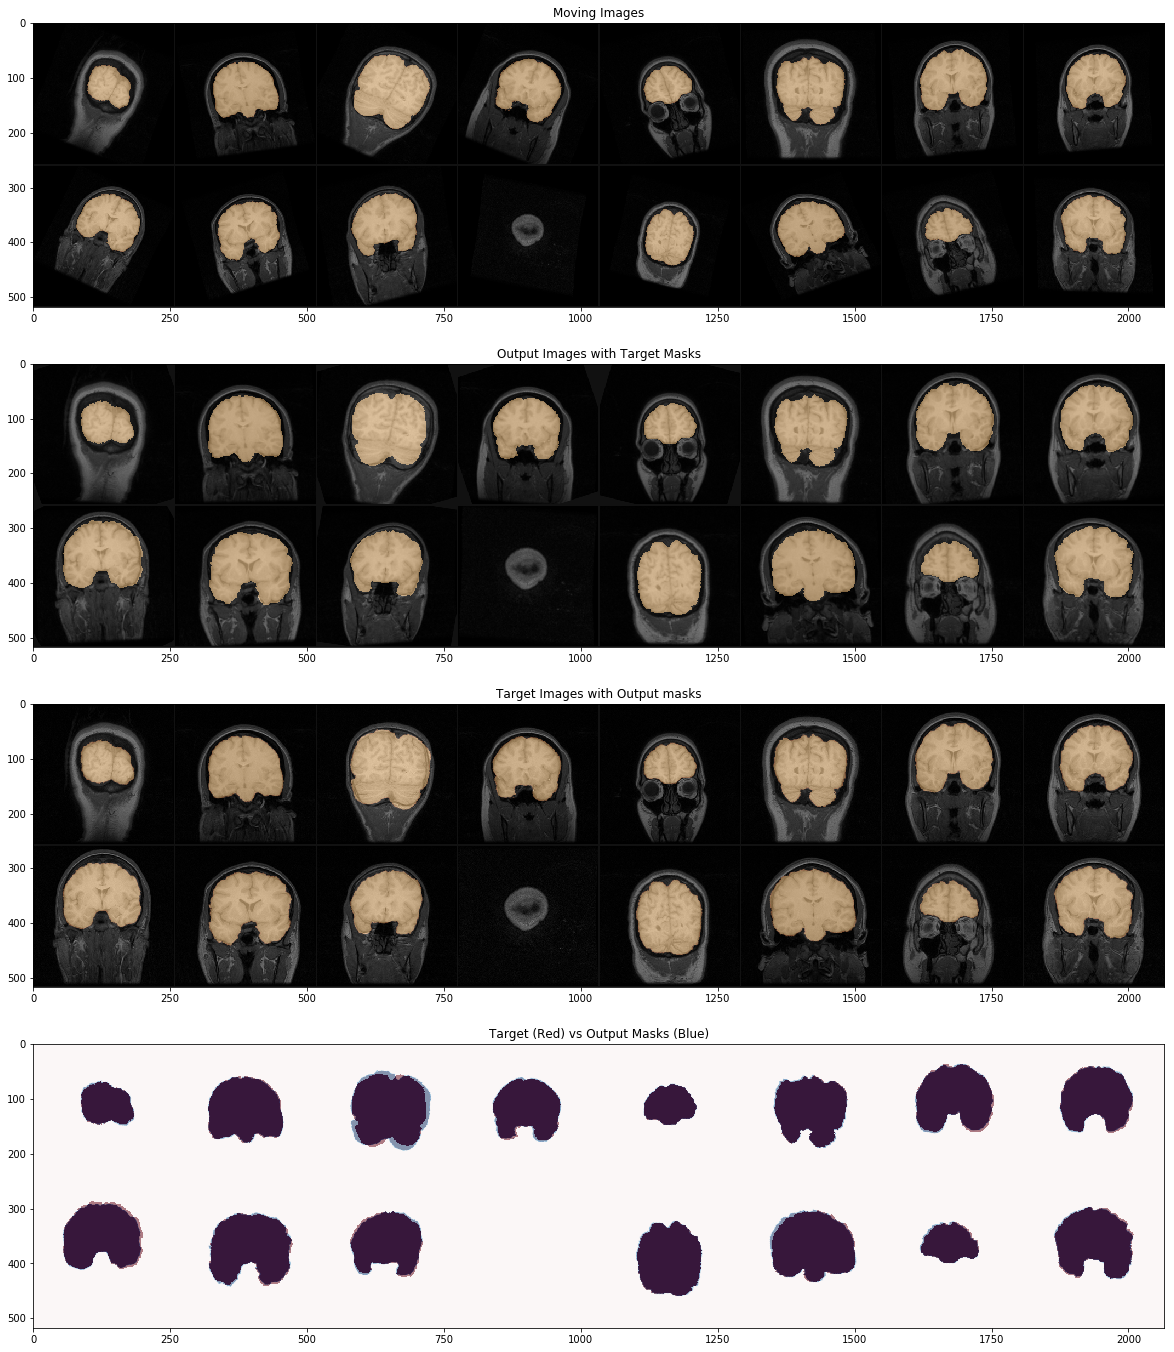

In [28]:
visualize_stn()